In [1]:
pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import evaluate
import numpy as np
import torch


In [4]:

# Data loading
df = pd.read_csv("/content/drive/MyDrive/balanced_full_codebert_dataset_filtered.tsv", sep="\t", escapechar="\\")


In [5]:
print(df.head())

             project_name                               commit_hash  \
0    github-datacollector  016be2175de269823c93835714be4d31bd78e35d   
1        github-eventapis  e68d3209f4491e06e89c083d4e2025b4d148bb67   
2  github-incubator-pinot  b6556a8dbea42149725799a9894138ab6125abb0   
3  github-incubator-pinot  54a21a8bfd2998c63dc349285d1f3fe9b7236b99   
4  github-incubator-pinot  54a21a8bfd2998c63dc349285d1f3fe9b7236b99   

  refactoring_type                                               code  
0       Move Class  package com.streamsets.pipeline.lib.stage.sour...  
1       Move Class  package com.kloia.eventapis.api.pojos;\n\nimpo...  
2       Move Class  package com.linkedin.pinot.tools;\n\nimport co...  
3       Move Class  package com.linkedin.pinot.core.transport;\n\n...  
4       Move Class  package com.linkedin.pinot.core.query.aggregat...  


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   project_name      33000 non-null  object
 1   commit_hash       33000 non-null  object
 2   refactoring_type  33000 non-null  object
 3   code              33000 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB
None


In [9]:
print(df.describe())

       project_name                               commit_hash  \
count         33000                                     33000   
unique          359                                     14259   
top      github-cas  e7b20da3a3ef6f6a29f4c3f359aafdf96da1e134   
freq           1955                                       337   

       refactoring_type                                               code  
count             33000                                              33000  
unique                5                                              21303  
top          Move Class  package org.nd4j.nativeblas;\n\nimport org.byt...  
freq               6600                                                129  


In [10]:
print(df.dtypes)

project_name        object
commit_hash         object
refactoring_type    object
code                object
dtype: object


In [6]:

# Removing the lines where refactoring_type = "no_refactoring"
df = df[~df["refactoring_type"].isin(["no_refactoring", "Extract Variable", "Move Method"])]


In [7]:

#Creating a list of labels
labels = sorted(df["refactoring_type"].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
df["label"] = df["refactoring_type"].map(label2id)


In [13]:
print(df.head())

             project_name                               commit_hash  \
0    github-datacollector  016be2175de269823c93835714be4d31bd78e35d   
1        github-eventapis  e68d3209f4491e06e89c083d4e2025b4d148bb67   
2  github-incubator-pinot  b6556a8dbea42149725799a9894138ab6125abb0   
3  github-incubator-pinot  54a21a8bfd2998c63dc349285d1f3fe9b7236b99   
4  github-incubator-pinot  54a21a8bfd2998c63dc349285d1f3fe9b7236b99   

  refactoring_type                                               code  label  
0       Move Class  package com.streamsets.pipeline.lib.stage.sour...      1  
1       Move Class  package com.kloia.eventapis.api.pojos;\n\nimpo...      1  
2       Move Class  package com.linkedin.pinot.tools;\n\nimport co...      1  
3       Move Class  package com.linkedin.pinot.core.transport;\n\n...      1  
4       Move Class  package com.linkedin.pinot.core.query.aggregat...      1  


In [14]:

print("Updated list of labels:", label2id)


Updated list of labels: {'Extract Method': 0, 'Move Class': 1, 'Pull Up Method': 2}


In [8]:

# Downloading the CodeBERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [9]:

# Sliding Window
def sliding_window_tokenization(code, tokenizer, max_length=256, stride=128):
    tokens = tokenizer.tokenize(code)
    segments = []

    for i in range(0, len(tokens), stride):
        segment = tokens[i : i + max_length]
        segments.append(tokenizer.convert_tokens_to_string(segment))

    return " ".join(segments)


In [10]:

# Applying the Sliding Window to the entire dataset
df["processed_code"] = df["code"].apply(lambda x: sliding_window_tokenization(x, tokenizer))


In [11]:

# Filtering of empty values
df = df[df["processed_code"].notna()]
df = df[df["processed_code"].str.strip() != ""]


In [12]:

# Converting a DataFrame to a Dataset
dataset = Dataset.from_pandas(df)

# Tokenization of the processed code
def tokenize_function(examples):
    return tokenizer(
        examples["processed_code"],
        padding="max_length",
        truncation=True,
        max_length=256  # CodeBERT processes up to 256 tokens at a time
    )


In [13]:

tokenized_dataset = dataset.map(tokenize_function, batched=True)



Map:   0%|          | 0/19800 [00:00<?, ? examples/s]

In [14]:
# train/test
split_ds = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = split_ds["train"]
test_ds = split_ds["test"]


In [15]:

# 📌 11. Loading CodeBERT
model = RobertaForSequenceClassification.from_pretrained(
    "microsoft/codebert-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:

# Improving the model parameters (adding a dropout)
model.config.hidden_dropout_prob = 0.4  # Optimal for stable learning
model.config.attention_probs_dropout_prob = 0.4  # Optimized Attention dropout


In [ ]:

# Metrics (Accuracy + F1)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


In [16]:
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix

# 📌 Загружаем метрики из evaluate
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=-1)

    # 📌 Accuracy
    accuracy = accuracy_metric.compute(predictions=y_pred, references=y_true)["accuracy"]

    # 📌 F1 (по умолчанию 'weighted' для многоклассовой классификации)
    f1 = f1_metric.compute(predictions=y_pred, references=y_true, average="weighted")["f1"]

    # 📌 Precision и Recall
    precision = precision_metric.compute(predictions=y_pred, references=y_true, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=y_pred, references=y_true, average="weighted")["recall"]

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [17]:

# Optimized learning parameters
training_args = TrainingArguments(
    output_dir="./codebert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=3e-5,
    weight_decay=0.05,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-18-f7764c8bf1e7>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:

# model training
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anastassyiasamuilova (anastassyiasamuilova-al-farabi-kazakh-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.734200,0.705687,0.703030,0.685123
2,0.518400,0.534124,0.795455,0.795783
3,0.413700,0.483188,0.836616,0.837031
4,0.285000,0.571587,0.836364,0.836130
5,0.242900,0.647531,0.852273,0.852015
6,0.146900,0.767776,0.846465,0.845843
7,0.093600,0.951032,0.844192,0.844132
8,0.074000,1.003514,0.841414,0.840754
9,0.052700,1.024950,0.846970,0.846628
10,0.042900,1.032129,0.847727,0.847436



📊 Confusion Matrix:
[[ 527  307  478]
 [  51 1168  129]
 [  54  157 1089]]

📊 Confusion Matrix:
[[1043   86  183]
 [ 280  979   89]
 [ 132   40 1128]]

📊 Confusion Matrix:
[[1086  123  103]
 [ 198 1086   64]
 [ 122   37 1141]]

📊 Confusion Matrix:
[[1080  108  124]
 [ 216 1050   82]
 [  95   23 1182]]

📊 Confusion Matrix:
[[1052  166   94]
 [ 159 1144   45]
 [  70   51 1179]]

📊 Confusion Matrix:
[[1024  183  105]
 [ 143 1149   56]
 [  69   52 1179]]

📊 Confusion Matrix:
[[1084  124  104]
 [ 210 1081   57]
 [  83   39 1178]]

📊 Confusion Matrix:
[[1047  138  127]
 [ 190 1090   68]
 [  66   39 1195]]

📊 Confusion Matrix:
[[1069  128  115]
 [ 190 1098   60]
 [  71   42 1187]]

📊 Confusion Matrix:
[[1069  133  110]
 [ 187 1103   58]
 [  73   42 1185]]


TrainOutput(global_step=9900, training_loss=0.2806312718776741, metrics={'train_runtime': 1847.8745, 'train_samples_per_second': 85.72, 'train_steps_per_second': 5.358, 'total_flos': 2.08385826840576e+16, 'train_loss': 0.2806312718776741, 'epoch': 10.0})

In [20]:
# Save model
trainer.save_model("./codebert_refactor_suggester")
tokenizer.save_pretrained("./codebert_refactor_suggester")


('./codebert_refactor_suggester/tokenizer_config.json',
 './codebert_refactor_suggester/special_tokens_map.json',
 './codebert_refactor_suggester/vocab.json',
 './codebert_refactor_suggester/merges.txt',
 './codebert_refactor_suggester/added_tokens.json')


📊 Confusion Matrix:
[[1052  166   94]
 [ 159 1144   45]
 [  70   51 1179]]


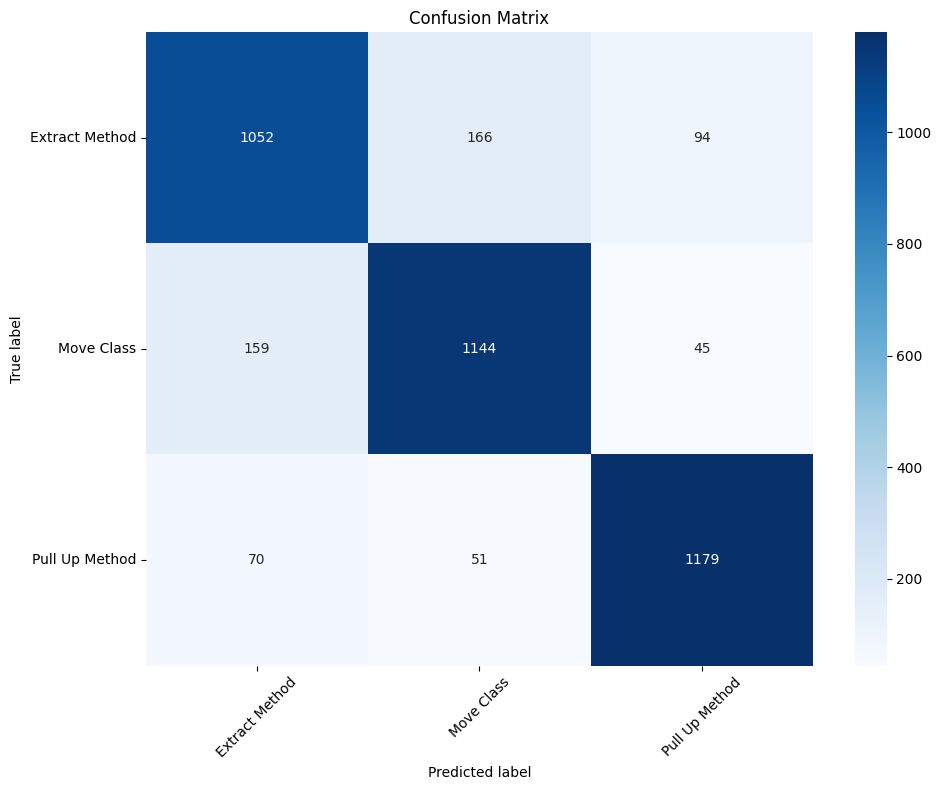

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 📌 Получаем предсказания от модели
preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# 📌 Конфузионная матрица
cm = confusion_matrix(y_true, y_pred)

# 📌 Метки классов
labels = list(id2label.values())

# 📌 Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
